In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, precision_recall_curve, PrecisionRecallDisplay
from pytorch_pretrained_bert import BertTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pytorch_pretrained_bert import BertModel
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
df = pd.read_csv('annotation_all.csv')
df = df.iloc[:,:2]
#df_valid = pd.read_csv('valid.csv')
df.columns = ['text', 'label']
#df_valid.columns = ['text', 'label']
#df.dropna()

print(df.shape)
df.head(5)

(787, 2)


,text,label
0,"You will work closely with our product, engine...",1
1,We're building and growing which means you'll ...,0
2,Leveraging our large amount of structured and ...,0
3,Experience mentoring and building a technical ...,0
4,MSc (PhD preferred) in hard sciences or comput...,0


0    545
1    242
Name: label, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels')

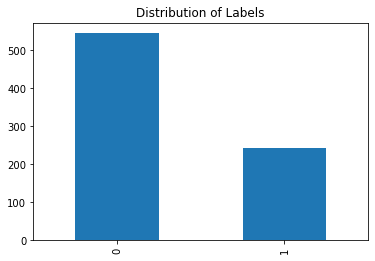

In [3]:
print(df['label'].value_counts())
df['label'].value_counts().plot.bar()
#plt.yscale('log');
plt.title('Distribution of Labels')

In [4]:
#train_df, val_df = train_test_split(df, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print('training set:', len(X_train))
print('validation set:', len(X_val))
print('test set:',len(X_test))

training set: 471
validation set: 158
test set: 158


In [5]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

#plt.yscale('log');

0    331
1    140
Name: label, dtype: int64
0    111
1     47
Name: label, dtype: int64
0    103
1     55
Name: label, dtype: int64


In [6]:
print('Average word length of questions in dataset is {0:.0f}.'.format(np.mean(df['text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in dataset is {0:.0f}.'.format(np.max(df['text'].apply(lambda x: len(x.split())))))
print('Average character length of questions in dataset is {0:.0f}.'.format(np.mean(df['text'].apply(lambda x: len(x)))))
print('Min character length of questions in dataset is {0:.0f}.'.format(np.min(df['text'].apply(lambda x: len(x.split())))))


Average word length of questions in dataset is 18.
Max word length of questions in dataset is 86.
Average character length of questions in dataset is 121.
Min character length of questions in dataset is 1.


Text(0.5, 1.0, 'Distribution of question text length in words')

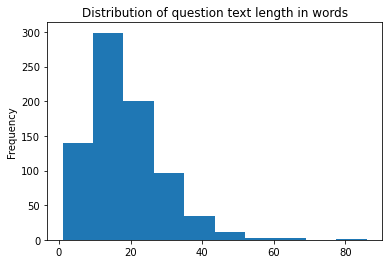

In [7]:
# Analyzing the Distribution of Question Text Length in Words
df['text'].apply(lambda x: len(x.split())).plot(kind='hist');
#plt.yscale('log');
plt.title('Distribution of question text length in words')


# Logistic regression & BERT

In [ ]:
# If you have your folder of data on your Google drive account, you can connect that here
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Change this to the directory with your data
directory="/content/drive/MyDrive/NLP/age_annotation"

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cpu


In [11]:
# import data
df = pd.read_csv('annotation_all.csv')
df = df.iloc[:,:2]
#df_valid = pd.read_csv('valid.csv')
df.columns = ['text', 'label']

#split train, test, dev data
######################################################

#train_df, val_df = train_test_split(df, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print(len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test))

471 471 158 158 158 158


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], X_train))
val_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], X_val))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], X_test))

In [13]:
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
val_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, val_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
val_tokens_ids = pad_sequences(val_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")

print(train_tokens_ids.shape, val_tokens_ids.shape, test_tokens_ids.shape)

(471, 512) (158, 512) (158, 512)


In [14]:
train_y = np.array(y_train) == 1
val_y = np.array(y_val) == 1
test_y = np.array(y_test) == 1
train_y.shape, val_y.shape, np.mean(train_y), np.mean(val_y)

((471,), (158,), 0.29723991507430997, 0.2974683544303797)

In [15]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
val_masks = [[float(i > 0) for i in ii] for ii in val_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [16]:
## Train baseline model and predict
######################################################
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression())
baseline_model = baseline_model.fit(X_train, y_train)

baseline_predicted = baseline_model.predict(X_test)
print(classification_report(y_test, baseline_predicted))

              precision    recall  f1-score   support

           0       0.75      0.97      0.84       103
           1       0.88      0.38      0.53        55

    accuracy                           0.77       158
   macro avg       0.81      0.68      0.69       158
weighted avg       0.79      0.77      0.74       158



In [17]:
#Bert model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(768, 1)

    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        # now you can implement any architecture that receives bert sequence output
        #pooled_output = 
        linear_output = self.linear(pooled_output)
        return linear_output

In [18]:
bert_clf = BertBinaryClassifier()
#bert_clf = bert_clf.cuda()

In [19]:
BATCH_SIZE = 5
EPOCHS = 15

In [20]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

val_tokens_tensor = torch.tensor(val_tokens_ids)
val_y_tensor = torch.tensor(val_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
val_masks_tensor = torch.tensor(val_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'


'0.0M'

In [21]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

val_dataset = TensorDataset(val_tokens_tensor, val_masks_tensor, val_y_tensor)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [22]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)
#loss_func = nn.BCEWithLogitsLoss().cuda()

loss_func = nn.BCEWithLogitsLoss().to(device)

In [26]:
from datetime import datetime
train_losses = []
val_losses = []
steps = []
step = 0
best_loss = float('inf')
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        # Forward Pass
        probas = bert_clf(token_ids, masks)
        
        # Find the Loss
        batch_loss = loss_func(probas, labels)

        # Calculate Loss
        train_loss += batch_loss.item()
        
        # Clear the gradients
        bert_clf.zero_grad()

        # Calculate gradients 
        batch_loss.backward()
        
        # Update Weights
        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} train_loss: {2} ".format(step_num, len(train_y) / BATCH_SIZE, train_loss / (step_num + 1)))
        train_losses.append(batch_loss.item())
        steps.append(step)
        step += 1

    # Evaluation on validation set
    bert_clf.eval() # Optional when not using Model Specific layer
    val_loss = 0
    with torch.no_grad():
        for step_num, batch_data in enumerate(val_dataloader):
            token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
            probas = bert_clf(token_ids, masks)
            batch_loss = loss_func(probas, labels)
            val_loss += batch_loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        
        model_path = 'model_{}_{}.pth'.format(timestamp, epoch_num)
        torch.save(bert_clf.state_dict(), model_path)
        #model_path = 'model_{}_{}'.format(timestamp, epoch_num)
        #torch.save(bert_clf, model_path)
    
    clear_output(wait=True)
    print('Epoch: ', epoch_num + 1)
    print("train_loss: {0:.4f} val_loss: {1:.4f}".format(train_loss / len(train_dataloader), val_loss))


Epoch:  50
train_loss: 0.0035 val_loss: 1.9211


In [23]:
mydevice = torch.device("cpu")
PATH = '/Users/catherineyu/andrewww/model_20230508_225640_6.pth'
model = BertBinaryClassifier()
model.load_state_dict(torch.load(PATH, map_location=mydevice))
#model.to(mydevice)

model.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(mydevice) for t in batch_data)

        logits = model(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()

        all_logits.append(numpy_logits)

test_logits = np.vstack(all_logits)


[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [24]:
# load trained model
mydevice = torch.device("cpu")
PATH = '/Users/catherineyu/andrewww/model_20230508_223209_4'
model = torch.load(PATH, map_location=mydevice)
## load model if saved as state_dict
#model = BertBinaryClassifier()
#model.load_state_dict(torch.load(PATH, map_location=mydevice))
model.to(mydevice)

model.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(mydevice) for t in batch_data)

        logits = model(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()

        all_logits.append(numpy_logits)

test_logits = np.vstack(all_logits)


In [27]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))


bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()

        all_logits.append(numpy_logits)

test_logits = np.vstack(all_logits)
        
#bert_predicted += list(sigmoid(test_logits[:, 0]>0.5))

Best Threshold=0.999542, F-Score=0.700
My Threshold=0.999943, F-Score=0.674


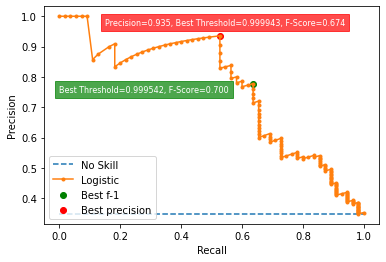

In [25]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

from sklearn.metrics import precision_recall_curve
from numpy import argmax

precision, recall, thresholds = precision_recall_curve(y_test, sigmoid(test_logits[:, 0]))

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
ip = np.argsort(precision, axis=0)[-7]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('My Threshold=%f, F-Score=%.3f' % (thresholds[ip], fscore[ip]))

# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='green', label='Best f-1')
plt.scatter(recall[ip], precision[ip], marker='o', color='red', label='Best precision')

plt.text(0, 0.75, 'Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]), fontsize = 8, 
         bbox = dict(facecolor = 'g', edgecolor = 'g', alpha = 0.7, ), color = 'w')

plt.text(0.15, 0.97, 'Precision=%.3f, Best Threshold=%f, F-Score=%.3f' % (precision[ip], thresholds[ip], fscore[ip]), fontsize = 8, 
         bbox = dict(facecolor = 'r', edgecolor = 'r', alpha = 0.7, ), color = 'w')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
# show the plot
plt.show()

In [26]:
print(classification_report(y_test,  sigmoid(test_logits[:, 0]) > 0.999542))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       103
           1       0.77      0.62      0.69        55

    accuracy                           0.80       158
   macro avg       0.79      0.76      0.77       158
weighted avg       0.80      0.80      0.80       158



<AxesSubplot:>

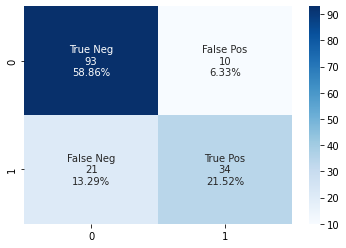

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, sigmoid(test_logits[:, 0]) > 0.999542)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')


In [28]:
predicted_label = sigmoid(test_logits[:, 0]) > 0.999542
test_newlabels = pd.DataFrame([X_test, y_test, predicted_label]).transpose()
test_newlabels.columns = ['text', 'true label', 'predicted label']
test_newlabels['predicted label'] = test_newlabels['predicted label'].apply(lambda x: 1 if x == True else 0)

test_newlabels.head()

,text,true label,predicted label
766,We’re looking for someone who is not afraid to...,0,0
101,Assist the Government in applying innovative a...,1,1
474,Ideal Candidates Will Have: -Multiple years of...,0,0
262,As a Data Scientist you will be working with t...,0,0
546,You will team up with business stakeholders to...,1,0


In [29]:
#false positive sentences
fp_sentences = test_newlabels.loc[(test_newlabels['true label']==0) & (test_newlabels['predicted label']==1)]['text']
n = 1
for i in fp_sentences:
    print(n,':',i)
    n+=1

1 : Design and build predictive customer behavior models for targeting and personalization
2 : The candidate will be responsible for end-to-endmachine learning model design and development. Success inthis role requires a strong foundation in machine learning, coupled with experience in big data and distributed computation.
3 : Work with and analyze large amounts of data. Interact with functional experts, at all levels, to understand the data challenges, user needs, and to identify new opportunities.
4 : You are passionate about generating hypotheses for business and product problems
5 : ARUP proudly hires top talent to create a work environment of diversity, professional growth and continuous development.


In [30]:
#false negative sentences
fn_sentences = test_newlabels.loc[(test_newlabels['true label']==1) & (test_newlabels['predicted label']==0)]['text']
n = 1
for i in fn_sentences:
    print(n,':',i)
    n+=1

1 : You will team up with business stakeholders to prioritize innovation ideas and work with other data scientists to develop and deliver breakthrough solutions
2 : The Dataiku Training Specialist must be ambitious, outgoing and tech-savvy, and must be prepared to learn new skills and work with different profiles and experiences in many interesting fields.
3 : The ideal candidate will be a quick learner, a self-starter, have good communication and time management skills, and work well in both independently and in a team environment
4 : Must also be able to deal with ambiguity and make independent decisions about what data and approach is best for the task at hand.
5 : Creative flair and ability to think outside the box
6 : Must be flexible and have the ability to handle many projects at one time
7 : Curiosity, enthusiasm, positive attitude and passion to build. Willingness to learn and research new concepts.
8 : Able to climb and descend stairs
9 : Can you quickly understand the fundin

# distilling bert


In [31]:
#distilling bert
train_dataset_for_distill = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_dataloader_for_distill = DataLoader(train_dataset, batch_size=BATCH_SIZE)

In [33]:
model.eval()
train_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(train_dataloader_for_distill):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = model(token_ids, masks)
        numpy_logits = logits.cpu().detach().numpy()
        
        train_logits.append(numpy_logits)
train_logits = np.vstack(train_logits)

In [34]:
print(classification_report(train_y, sigmoid(train_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00       331
        True       0.99      1.00      0.99       140

    accuracy                           1.00       471
   macro avg       0.99      1.00      0.99       471
weighted avg       1.00      1.00      1.00       471



In [38]:
distilled_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LinearRegression()).fit(X_train, train_logits)

# predict probabilities
#lr_probs = distilled_model.predict_proba(test_texts)
# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]

# predict class values
distilled_predicted_logits = distilled_model.predict(X_test)
#lr_precision, lr_recall, _ = precision_recall_curve(test_y, lr_probs)
#lr_f1, lr_auc = f1_score(test_y, distilled_predicted_logits), auc(lr_recall, lr_precision)

print(classification_report(y_test, sigmoid(distilled_predicted_logits[:, 0]) > 0.5))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       103
           1       0.81      0.38      0.52        55

    accuracy                           0.75       158
   macro avg       0.78      0.67      0.68       158
weighted avg       0.77      0.75      0.72       158



(array([328.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,   0., 139.]),
 array([-10.605576  ,  -8.523482  ,  -6.441389  ,  -4.3592954 ,
         -2.2772021 ,  -0.19510889,   1.8869845 ,   3.9690778 ,
          6.0511713 ,   8.133265  ,  10.215358  ], dtype=float32),
 <BarContainer object of 10 artists>)

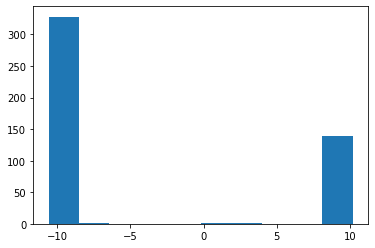

In [39]:
plt.hist(train_logits)

# label new data using the trained model

In [42]:
#label unlabeled data
unlabeled_texts = []
with open('unlabeled_clean.txt') as f:
    for line in f:
        unlabeled_texts.append(line.strip())

unlabeled_texts[:5]

['The Customer Service Associate will be based in Seattle, WA.',
 'The right candidate will be an integral part of our talented team, supporting our continued growth.Responsibilities include, but are not limited to:Prepare materials for mailing including: applying postage, preparing items for shipment or collection, distributing items as needed, ensuring items are properly labeled and documenting data according to management guidelines.Perform start-up and operations of postage equipment.Ensure that all mail and packages are properly labeled for mailing, with correct postage utilizing automatic postage meter machine.Sort, deliver and pick-up mail and packages utilizing mail cart according to established time frames and service standards.Assist with loading and unloading of deliveries as needed.Maintain shipping and receiving area as required.Sort and process inbound intercompany mail.Scan and input inbound accountable boxes and packages including certified, registered, return receipt, 

In [43]:
# use distilled model to label unlabeled text data
unlabeled_logits = distilled_model.predict(unlabeled_texts)
prediction = tf.round(tf.nn.sigmoid(unlabeled_logits)) 
#predicted_label = sigmoid(distilled_predicted_logits[:, 0]) > 0.5

In [44]:
predicted_label = prediction.numpy().flatten()
unlabeled_text_labeles = pd.DataFrame([unlabeled_texts, predicted_label]).transpose()
unlabeled_text_labeles.columns = ['text', 'label']
unlabeled_text_labeles.head()


,text,label
0,The Customer Service Associate will be based i...,0.0
1,The right candidate will be an integral part o...,0.0
2,Ability to lift heavy boxes and operate electr...,0.0
3,"To strengthen its new executive team, Axonix i...",0.0
4,"We're seeking a hands-on executer, who can spa...",0.0


In [45]:
predicted_discriminitory_sentences = unlabeled_text_labeles.loc[unlabeled_text_labeles['label']==True]['text']
n = 1
for i in predicted_discriminitory_sentences:
    print(n,':',i)
    n+=1

1 : Join a fast growing technology education movement!Apps for Good (#URL_937118d268463f038aabd860063eb978f7ad6c0a78ed8e595e39bfa1de380e90#) is an award-winning technology education movement where young people in schools learn to create apps that solve problems they care about and change their world.
2 : We are looking for a specialized game developer to turn a game idea into code on a fast moving environment.
3 : •5+ years of experience as a Teradata DBA•7-10 years of overall experience as a developer &amp; DBA role in IT field.
4 : In the past three years, online marketing has evolved from simple email newsletters and campaign websites, to high performance, high availability web applications, mobile apps, Facebook integrations and digital out of home experiences, with creatively designed and highly interactive user interfaces.
5 : Food52, a fast-growing, James Beard Award-winning online food community, recipe hub, and home and kitchen shop, is currently looking for part-time, seasona

0.0    557
1.0     44
Name: label, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels')

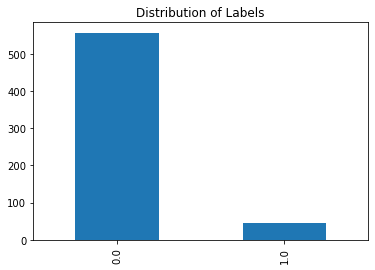

In [46]:
from matplotlib import pyplot as plt
print(unlabeled_text_labeles['label'].value_counts())
unlabeled_text_labeles['label'].value_counts().plot.bar()
#plt.yscale('log');
plt.title('Distribution of Labels')

# find words in the word corpus

In [ ]:
from reversestem import unstem

In [ ]:
word_corpus = []
with open('word_corpus.txt') as f:
    for line in f:
        word_corpus.append(line.strip())

word_corpus

['vibrant',
 'active',
 'energetic',
 'witty',
 'high-performer',
 'high performer',
 'ambitious',
 'fun',
 'dynamic',
 'adaptable',
 'creative',
 'sharp',
 'tech-savvy',
 'tech savvy',
 'quick-learner',
 'quick learner',
 'adaptable',
 'flexible',
 'creative',
 'innovative',
 'fast learner',
 'fast-learner',
 'recent college graduate',
 'youthful',
 'GPA']

In [ ]:
ageist_word_corpus_unstem = []
for i in word_corpus:
    try:
        unstemmed_words = unstem(i, flatten=True)
        if unstemmed_words == None:
            ageist_word_corpus_unstem.append(i)
        else:
            ageist_word_corpus_unstem.extend(unstemmed_words)
    except:
        print(i)
        ageist_word_corpus_unstem.append(i)


fun
adaptable
creative
sharp
adaptable
creative
innovative


In [ ]:
text = predicted_discriminitory_sentences.iloc[0]
print(text)
for word in word_corpus:
    if text.lower().count(word) != 0:       
        print(word, text.lower().count(word))

Join a fast growing technology education movement!Apps for Good (#URL_937118d268463f038aabd860063eb978f7ad6c0a78ed8e595e39bfa1de380e90#) is an award-winning technology education movement where young people in schools learn to create apps that solve problems they care about and change their world.
